In [ ]:
import os
import sys
sys.path.insert(0, "../")
from MVB.nn import GaussianLinear
from MVB.nn import GaussianConv2d
from MVB.nn import GaussianParameter
from MVB.nn.utils import MixturePenalty, SetMixturePrior, CalculateDropThreshold, SetThreshold, LockEpsilon, RollEpsilon
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import math
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from numpy import savetxt

In [724]:
p = 1
X = torch.arange(-3, 3, 0.005).reshape((1200, 1))## generate X of (n=1000, p = 10) each element follows N(0,1)

train_dataset = X

In [725]:
h = 200

# a neural network with 1 hidden layer that input 10 dimension x and output 1 dimension y hat with relu as activation function
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = GaussianLinear(p, 20)
        self.fc2= GaussianLinear(20,20)
        self.fc3= GaussianLinear(20,h)
        self.fc4= GaussianLinear(h,1)
        ## eta = log sigma^2, where sigma^2 is the variance for iid noise in regression setting
        ## to apply our framework, estimate sigma^2 is a must since we need complete likelihood information while combine
        ## with the spike slab prior
        self.eta = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out
    
    ## customer function to compute estimated noise variance from eta
    def getSigmaSq(self):
        return torch.exp(self.eta)

In [726]:
num_epochs = 50
batch_size = 1
#learning_rate = 0.05
#scheduler_step_size = 100
#scheduler_gamma = 1
#optim = 'SGD'

#seed = 58810

#torch.manual_seed(seed)

In [727]:
## insert data into train loader and test loader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)
# test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
#                                           batch_size = batch_size,
#                                           shuffle = False)

In [728]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('results/model_bl1.pt').to(device)

#criterion = nn.CrossEntropyLoss()

In [730]:
yhat = model(X.to(device)).detach()

In [732]:
xs = X[:, 0:1].cpu().numpy()
y_hat =yhat[:, 0:1].cpu().numpy()

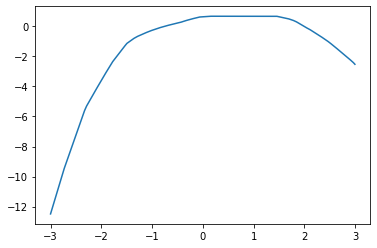

In [733]:
plt.plot(xs, y_hat)

In [734]:
## put model into lock epsilon mode

grads_sum = torch.zeros((len(X), 1 ), device  = "cuda")

grads_sum

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [735]:
## compute gradient against each pixel
LockEpsilon(model)
start_time = time.time()
for epoch in range(num_epochs):
    #roll epsilon in each simulation
    RollEpsilon(model)
    grads = torch.empty(size=(len(train_loader), p), device = device)
    i = -1
    for observation in train_loader:
        i+=1
        x = observation[:,:p].to(device)
        #images.requires_grad = True
        #outputs = model(images)

        grad = torch.autograd.functional.jacobian(model, x)
        grads[i] = grad.clone()[0,0,0,:]
        
    
    torch.save(grads, 'results/jacobian/run' + str(epoch+1) + '.pt')
    grads_sum = torch.add(grads_sum ,grads)
    print('Run: {}, Time: {:.4f}'.format(epoch+1, time.time() - start_time))

Run: 1, Time: 3.1911
Run: 2, Time: 6.4823
Run: 3, Time: 9.8766
Run: 4, Time: 13.2100
Run: 5, Time: 16.3621
Run: 6, Time: 19.6185
Run: 7, Time: 22.8938
Run: 8, Time: 26.1471
Run: 9, Time: 29.4131
Run: 10, Time: 32.7113
Run: 11, Time: 35.9857
Run: 12, Time: 39.2671
Run: 13, Time: 42.5274
Run: 14, Time: 45.7905
Run: 15, Time: 49.0587
Run: 16, Time: 52.3262
Run: 17, Time: 55.5931
Run: 18, Time: 58.8573
Run: 19, Time: 62.1260
Run: 20, Time: 65.2831
Run: 21, Time: 68.4802
Run: 22, Time: 71.7439
Run: 23, Time: 75.0148
Run: 24, Time: 78.3087
Run: 25, Time: 81.5488
Run: 26, Time: 84.7093
Run: 27, Time: 88.0401
Run: 28, Time: 91.2962
Run: 29, Time: 94.5658
Run: 30, Time: 97.8276
Run: 31, Time: 101.0923
Run: 32, Time: 104.2936
Run: 33, Time: 107.5572
Run: 34, Time: 110.8177
Run: 35, Time: 114.0654
Run: 36, Time: 117.3252
Run: 37, Time: 120.5896
Run: 38, Time: 123.7611
Run: 39, Time: 126.9248
Run: 40, Time: 130.1545
Run: 41, Time: 133.4374
Run: 42, Time: 136.7749
Run: 43, Time: 140.1255
Run: 44, T

In [739]:
ys = grads[:,0:1].cpu().numpy()

dat= np.concatenate((xs, y_hat, ys), axis = 1)
dat

array([[ -3.       , -12.483518 ,  10.482657 ],
       [ -2.995    , -12.427041 ,  10.482657 ],
       [ -2.99     , -12.370565 ,  10.482657 ],
       ...,
       [  2.9850001,  -2.488496 ,  -5.341685 ],
       [  2.99     ,  -2.5067735,  -5.341685 ],
       [  2.9950001,  -2.525052 ,  -5.3592753]], dtype=float32)

In [740]:
for epoch in range(num_epochs - 1):
    r = torch.load('results/jacobian/run' + str(epoch+1) + '.pt').to(device)
    ys = r[:,0:1].cpu().numpy()
    dat = np.concatenate ((dat, ys), axis = 1)

In [741]:
dat

array([[ -3.       , -12.483518 ,  10.482657 , ...,  12.249157 ,
          9.993895 ,  11.026548 ],
       [ -2.995    , -12.427041 ,  10.482657 , ...,  12.249157 ,
          9.993895 ,  11.026548 ],
       [ -2.99     , -12.370565 ,  10.482657 , ...,  12.347279 ,
          9.993895 ,  11.026548 ],
       ...,
       [  2.9850001,  -2.488496 ,  -5.341685 , ...,  -3.6423965,
         -5.454033 ,  -3.9519715],
       [  2.99     ,  -2.5067735,  -5.341685 , ...,  -3.6423965,
         -5.454033 ,  -3.9519715],
       [  2.9950001,  -2.525052 ,  -5.3592753, ...,  -3.6423965,
         -5.454033 ,  -3.9519715]], dtype=float32)

In [743]:
savetxt('dat_4l_mix_b4_r50.csv', dat, delimiter=',')

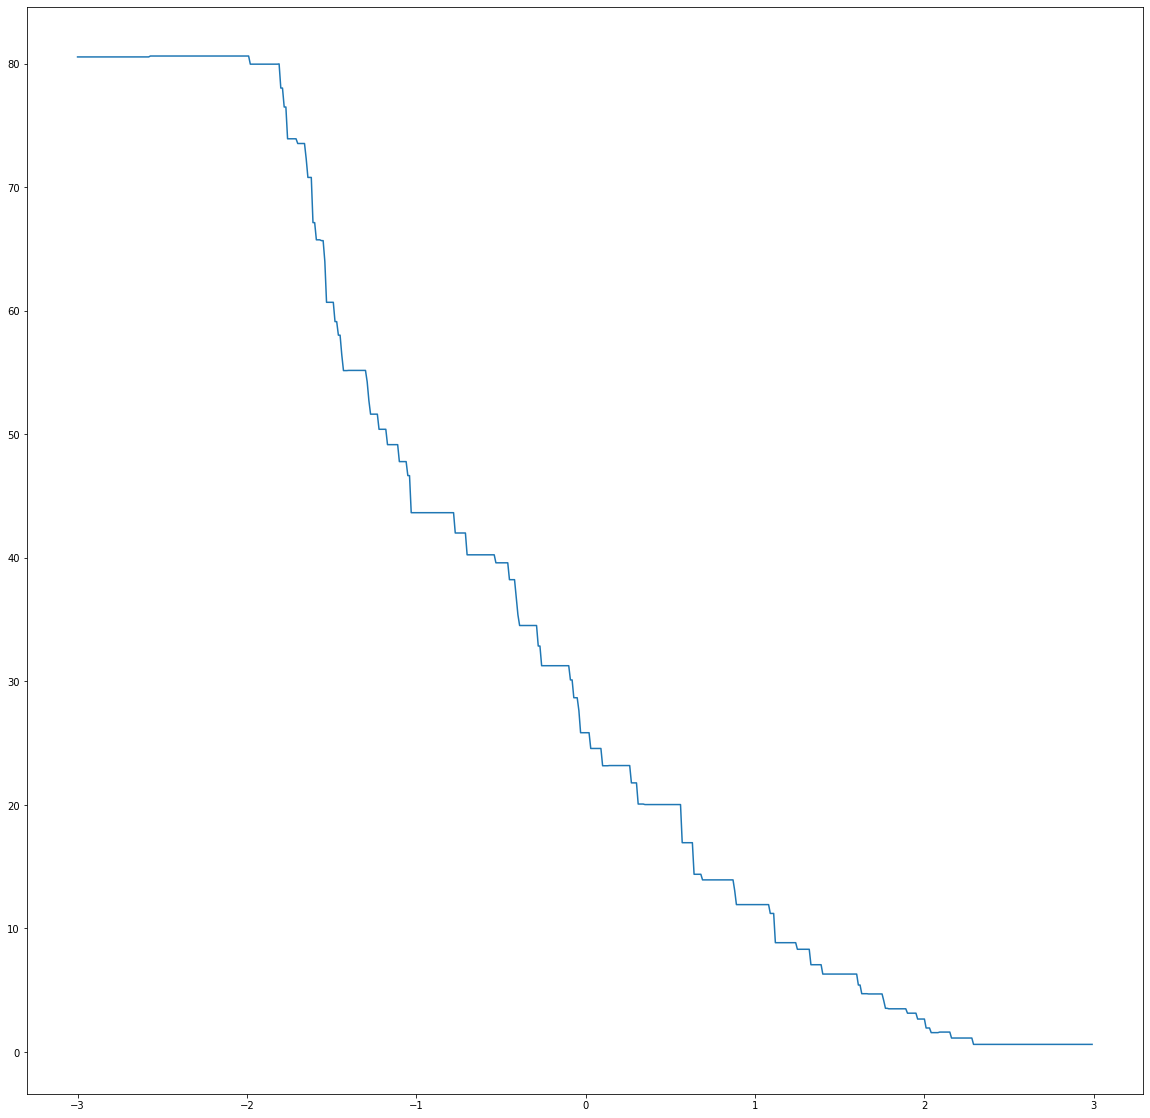

In [515]:
plt.figure(figsize=(20,20))
xs = train_dataset[:,0:1].cpu().numpy()
ys = grads_mean[:,0:1].cpu().numpy()

xs, ys = zip(*sorted(zip(xs, ys)))

plt.plot(xs, ys)